# Signalanalyse

## Laden der benötigten Pakete

In [1]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import pandas as pd
from scipy import fftpack
% matplotlib inline

Festlegung einiger visueller Einstellungen

In [2]:
# Größe
plt.rcParams['figure.figsize'] = [10.0, 3.0]
# Auflösung
plt.rcParams['figure.dpi'] = 100
# Komma statt Punkt
plt.rcParams['axes.formatter.use_locale'] = True

## Analyse einer harmonische Schwingungen
Im folgenden soll nun eine harmonische Schwingungen analysiert werden, die in vielen elektrischen Maschinen, z.B. Motoren und Induktivanlagen auftreten.

In [3]:
# generate signals for voltage and current
fs = 10e6
N = np.int(1e6)
f1 = 300e3
f2 = 330e3
N_deltaf = 50
U_0 = 1000
U_1 = 1100
I_0 = 3000
I_1 = 2950
f = np.concatenate([np.ones(N // 2 - N_deltaf // 2) * f1,
                    np.linspace(f1, f2),
                    np.ones(N // 2 - N_deltaf // 2) * f2])
t = np.arange(N) / fs
u = U_0 * np.sin(2 * np.pi * f * t) + 0.02 * U_0 * np.random.randn(N)
u[len(u)//2:] = u[len(u)//2:]/U_0*U_1
i = I_0 * np.sin(2 * np.pi * f * t - 89 / 180 * np.pi) + 0.02 * I_0 * np.random.randn(N)
i[len(i)//2:] = i[len(i)//2:]/I_0*I_1

# save data to hdf5
np.savez('harmonics.npz', t=t, u=u, i=i)

In [4]:
with np.load('harmonics.npz') as data:
    t = data['t']
    u = data['u']
    i = data['i']

Anschließend sind die Daten in den Variablen `t` für die Abtastzeitpunkte, `u` für die Spannungswerte und `i` für die Stromwerte vorhanden.

Stelle die Daten geladenen Daten dar
* Spannung auf der linken y-Achse
* Strom auf der rechten y-Achse

Achten Sie dabei auf korrekte Achsenbeschriftung.

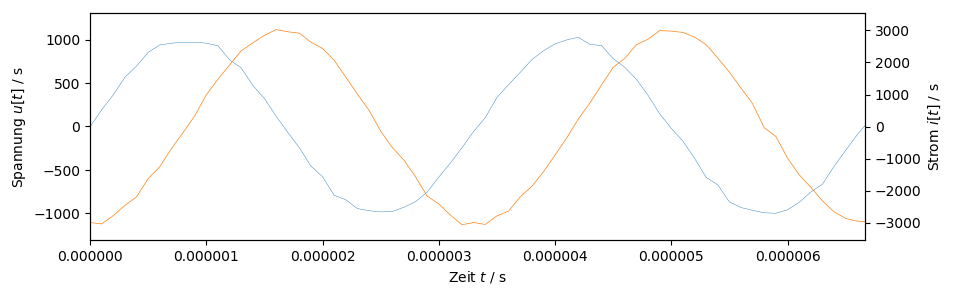

In [5]:
fh, ah = plt.subplots(1, 1)
ah = [ah, plt.twinx(ah)]
ah[0].plot(t, u, linewidth=0.3)
ah[0].set_xlim([0, 2/f1])
ah[0].set_xlabel(r'Zeit $t$ / s')
ah[0].set_ylabel(r'Spannung $u\left[t\right]$ / s')
ah[1].plot(t, i, color='C1', linewidth=0.5)
ah[1].set_ylabel(r'Strom $i\left[t\right]$ / s')
plt.show()

### Berechnung der Effektivwerte

Nun sollen aus den geladenen Daten die Effektivwerte für eine bestimmte Anzahl (`N = 10000`) von Messwerten iterativ bestimmt werden.

Der Effektivwert ist analytisch folgendermaßen definiert:
$$X_\mathrm{eff} = \sqrt{\frac{1}{T} \int\limits_{t_0}^{t_0 + T} x^2 \, \mathrm{d}t}$$
Dabei ist $x$ das Zeitsignal und $T$ die Länge eines Fensters.

Wir wollen den Effektivwert nurmerisch bestimmen und können ihn daher nährungsweise mittels
$$X_\mathrm{eff} \approx \sqrt{\frac{1}{N} \sum\limits_{n = 1}^N x_n^2}$$
bestimmen für ein Fenster der Länge `N` bestimmen.

Teilaufgaben/-probleme:
* Erzeuge dir vorab Matrizen mittels [`numpy.zeros`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html) Matrizen für die Effektivwerte von Spannung `u` und Strom`i`.
  Die Fenster sollen `N = 10000` Messwerte lang sein, die Größe des Arrays bestimmt sich also über die Division `len(u) // N`
* Vergiss nicht auch eine neue Zeit zu berechnen an dem der Effektivwert später in der Grafik eingetragen wird
* Überlege dir wie du die korrekte Anzahl Messwerte in `u` und `i` mittels *slicing* ansprichst: https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
* Stelle die Ergebnisse anschließend korrekt beschriftet dar (Spannung links, Strom rechts)

In [6]:
window = 10000
t_window = np.zeros(N // window)
U_eff = np.zeros(N // window)
I_eff = np.zeros(N // window)
for ii in np.arange(U_eff.size):
    t_window[ii] = np.mean(t[ii * window : (ii + 1) * window + 1])
    U_eff[ii] = np.sqrt(np.mean(np.power(u[ii * window : (ii + 1) * window + 1], 2)))
    I_eff[ii] = np.sqrt(np.mean(np.power(i[ii * window : (ii + 1) * window + 1], 2)))

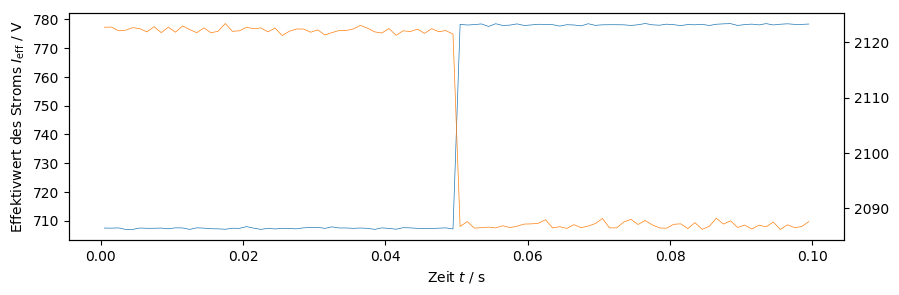

In [7]:
fh, ah = plt.subplots(1, 1)
ah = [ah, plt.twinx(ah)]
ah[0].plot(t_window, U_eff, linewidth=0.5)
ah[0].set_xlabel(r'Zeit $t$ / s')
ah[0].set_ylabel('Effektivwert der Spannung $U_\mathrm{eff}$ / V')
ah[1].plot(t_window, I_eff, 'C1', linewidth=0.5)
ah[0].set_ylabel('Effektivwert des Stroms $I_\mathrm{eff}$ / V')
plt.show(fh)

### Berechnung der Wirkleistung
Nun soll die Wirkleistung auch für je eine bestimmte Anzahl Messwerte berechnet werden. Die Wirkleistung ist analytisch folgendermaßen definiert:
$$P = \overline{p} = \frac{1}{T} \int\limits_{t_0}^{t_0 + T} u \cdot i \, \mathrm{d}t$$
Numerisch lässt sie sich mittels
$$P \approx \sqrt{\frac{1}{N} \sum\limits_{n = 1}^N u_n \cdot i_n}$$
approximieren. Gehe genauso vor wie bei der Wirkleistung.

In [8]:
window = 10000
t_window = np.zeros(N // window)
power = np.zeros(N // window)
for ii in np.arange(power.size):
    t_window[ii] = np.mean(t[ii * window : (ii + 1) * window + 1])
    power[ii] = np.mean(u[ii * window : (ii + 1) * window + 1] * i[ii * window : (ii + 1) * window + 1])

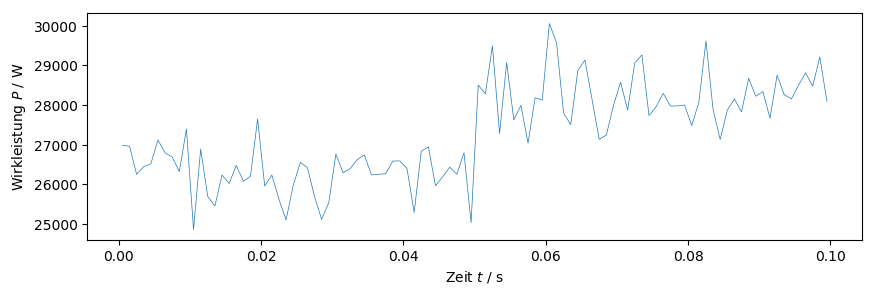

In [9]:
fh, ah = plt.subplots(1, 1)
ah.plot(t_window, power, linewidth=0.5)
ah.set_xlabel(r'Zeit $t$ / s')
ah.set_ylabel(r'Wirkleistung $P$ / W')
plt.show(fh)

### Bonus: Berechnung des (Kurzzeit-)Spektrums
Abschließend soll das Kurzzeitspektrum (STFT) des Signals berechnet werden. Verwende dafür die Funktion [matplotlib.pyplot.specgram](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html), variiere dabei den Parameter `NFFT` und `noverlap`.

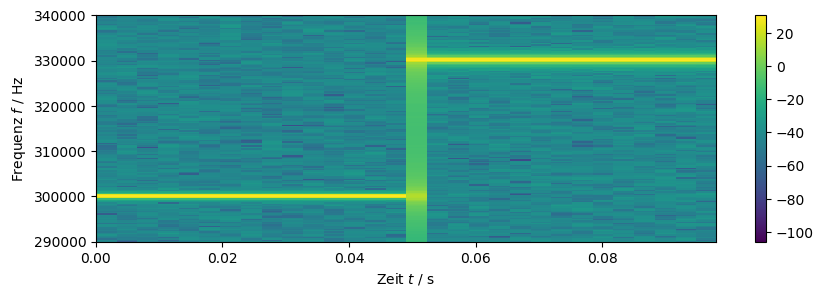

In [10]:
fh, ah = plt.subplots(1, 1)
_, _, _, im = ah.specgram(u, Fs=fs, NFFT=2**15)
ch = plt.colorbar(im)
ah.set_ylim([290e3, 340e3])
ah.set_xlabel(r'Zeit $t$ / s')
ah.set_ylabel(r'Frequenz $f$ / Hz')
plt.show(fh)